In [611]:
import json
import logging
import requests
import math

from requests import Request, Session

from requests.auth import HTTPBasicAuth

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

alt.data_transformers.enable("vegafusion")


DataTransformerRegistry.enable('vegafusion')

In [612]:
def get_config():
    logging.getLogger().debug("get config")

    with open('config.json', "r") as f:
        config = json.load(f)

    return config

In [613]:
def get_collibra(config):
    logging.getLogger().debug("get collibra")

    collibra = {}

    collibra["host"] = f"https://{config['collibra_host']}"

    collibra["username"] = config['collibra_username']

    collibra["password"] = config['collibra_password']

    collibra["endpoint"] = f"{collibra['host']}{config['collibra_api_endpoint']}"

    collibra["session"] = Session()

    collibra.get("session").auth = HTTPBasicAuth(collibra.get("username"), collibra.get("password"))

    return collibra

In [614]:
def get_response(method, url, data, limit, session):
    logging.getLogger().debug("send request")

    offset = 0
    
    results = []

    while True:
        request = Request(
            method=method,
            url=f"{url}&offset={offset}&limit={limit}",
            headers = {'accept': 'application/json', 'Content-Type': 'application/json'},
            data = data
        )

        request = session.prepare_request(request)
   
        response = session.send(request)

        if response.status_code != requests.codes.ok: raise Exception(f'Error: {response.text}') 

        if not response.json()['results']: break

        results = results + response.json()['results']

        offset+=limit

    return results

In [615]:
def get_names_per_database(names_per_database, names):
    dbname = f"{names[0]}>{names[1]}"

    if dbname not in names_per_database:
        names_per_database[dbname] = []

    if names[2].upper() not in names_per_database[dbname]:
        names_per_database[dbname].append(names[2].upper())

    if names[3].upper() not in names_per_database[dbname]:
        names_per_database[dbname].append(names[3].upper())

    return names_per_database


In [616]:
def jaccard_similarity(x, y):
  intersection_cardinality = len(set.intersection(*[set(x), set(y)]))

  union_cardinality = len(set.union(*[set(x), set(y)]))

  #return round(intersection_cardinality/float(union_cardinality) *100)
  return intersection_cardinality/float(union_cardinality)

In [617]:
def update_matrix(matrix, x, y, v):
    matrix[x][y] = v


In [618]:
def main():
    config = get_config()

    collibra = get_collibra(config)

    response = get_response("GET", f"{collibra.get('endpoint')}/assets?typePublicIds=Table&typeInheritance=true&sortField=NAME&sortOrder=ASC", None, 1000, collibra.get("session"))

    all_table_names = list(map(lambda x: f"{x['domain']['id']}>{x['name']}".split('>'), filter(lambda x: x['name'].count('>')==3 , response))) # only tables complying with the new edge naming convention c>d>s>t

    names_per_database = {}

    _=list(map(lambda x: get_names_per_database(names_per_database, x), all_table_names)) 

    # build empty matrix 
    n = len(names_per_database.keys())
    arr = np.array([None] *n*n, dtype=float)

    matrix = arr.reshape(n, n)


    # update matrix with similarity
    l=list(names_per_database.keys())
    
    _=[update_matrix(matrix, i, ii, jaccard_similarity(l[i],l[ii])) for i, n in enumerate(matrix) for ii, nn in enumerate(matrix[i])]

    similarity_df = pd.DataFrame(matrix, columns=list(names_per_database.keys()), index=list(names_per_database.keys()))
    
    similarity_df_melted = pd.melt(similarity_df.reset_index(), id_vars=['index'], value_vars=similarity_df.columns)

    return matrix, similarity_df, similarity_df_melted

In [619]:
if __name__ == '__main__':
    matrix, similarity_df, similarity_df_melted = main() 

In [620]:
# done

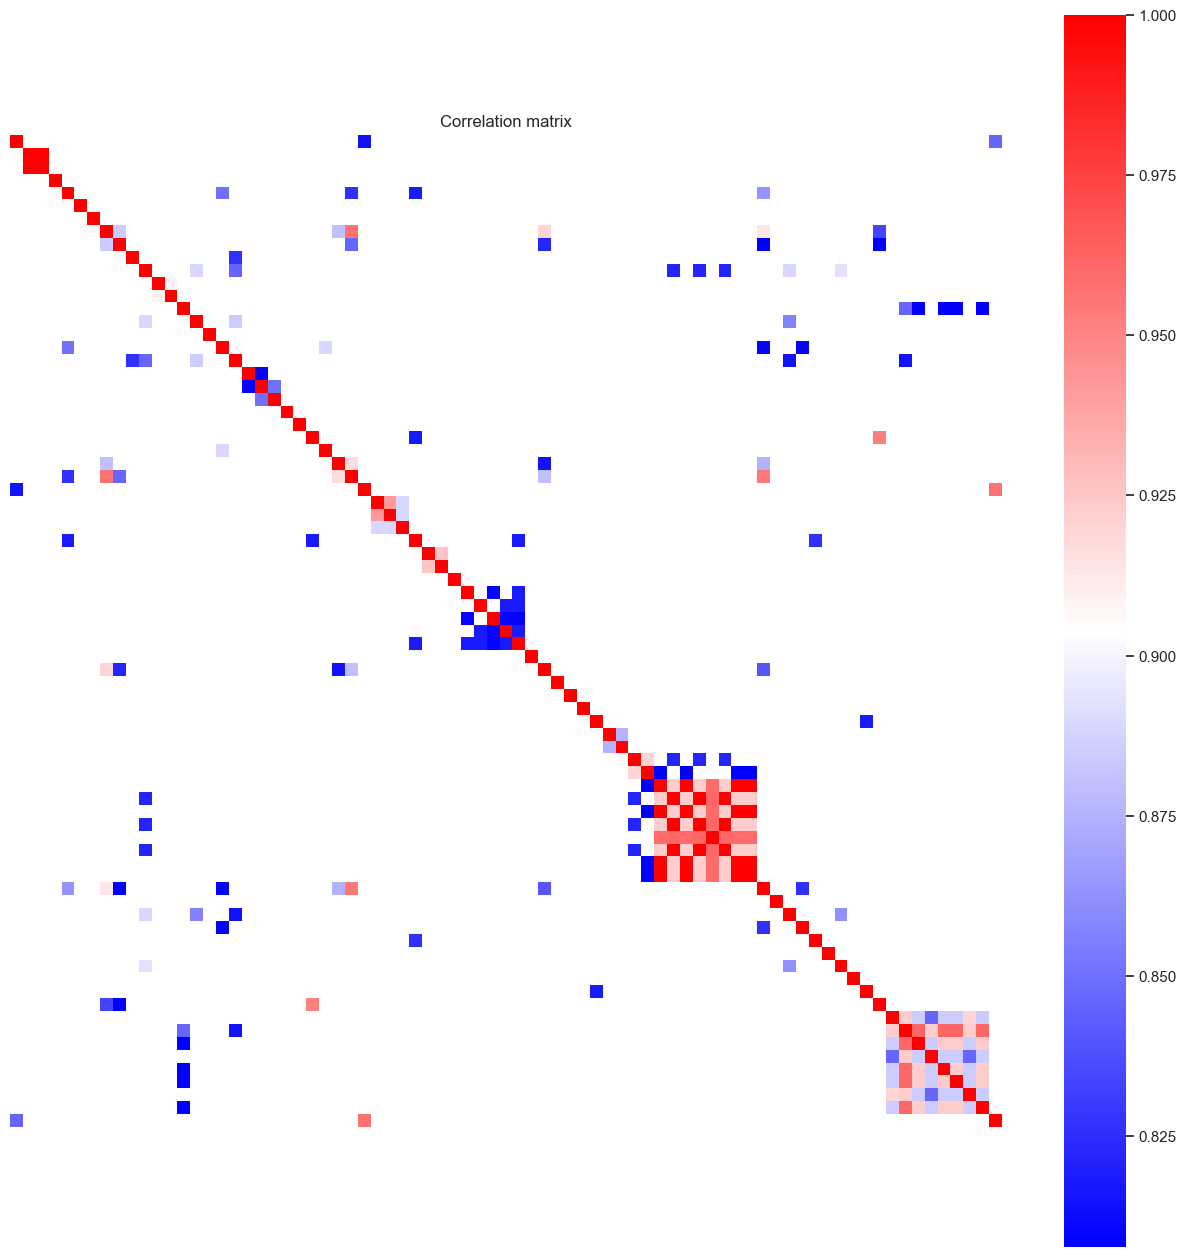

In [621]:
sns.set_theme(style='whitegrid')

fig=plt.figure(figsize=(16,16))

mask = np.where(matrix <= 0.8, True, False)

sns.heatmap(similarity_df, cmap='bwr', xticklabels=False, yticklabels=False, square=True, mask =mask)

sns.despine(left=True,bottom=True)

plt.title('Correlation matrix')

plt.show()

In [622]:

mask = 'value >.9'

alt.Chart(similarity_df_melted.query(mask)).mark_rect().encode(
    alt.X('variable', axis=alt.Axis(labels=False, labelAngle=0)).title('Finding severity'),
    alt.Y('index', axis=alt.Axis(labels=False, labelAngle=0)).title('Resource type'),
    alt.Color('value', legend=None).scale(scheme="orangered", reverse=False),
    alt.Text('value'), 
    tooltip=["variable","index","value"]
).properties(title='Similarity', width=1100, height=1100)


alt.Chart(...)

In [ ]:
#done